In [107]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [108]:
# activation = torch.nn.ReLU()
# activation_name = 'relu'

# activation = torch.nn.Sigmoid()
# activation_name = 'sigmoid'

activation = torch.nn.Tanh()
activation_name = 'tanh'

# activation = torch.nn.LeakyReLU()
# activation_name = 'leaky_relu'

# activation = torch.nn.SiLU()
# activation_name = 'silu'


In [109]:
np.random.seed(42) # We want same sequence of random numbers each time

# Creating a dataset

Run all cells from here multiple times to record trainning of selected activation function


After all training proccess have been recoreded, then use the looses_comparision.ipynb to compare the losses of the model

In [4]:
NUM_CLASSES = 5
NUM_FEATURES = 2
RANDOM_SEED = np.random.randint(0, 1000) # For cluster initialization
# torch.manual_seed(RANDOM_SEED) # For model initialization
TEST_SIZE = 0.2
LEARNING_RATE = 0.01
EPOCHS = 500

save_figs = False

In [5]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [43]:
# Blobs
# X_blob, Y_blob = make_blobs(n_samples=1000,
#                             n_features=NUM_FEATURES,
#                             centers=NUM_CLASSES,
#                             random_state=RANDOM_SEED,
#                             cluster_std=1.5,
#                             )
X_blob, Y_blob = make_circles(n_samples=1000,
                             shuffle=True,
                             noise=0.1,
                             random_state=RANDOM_SEED,
                             factor=0.7
                             )

X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.float)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_blob, Y_blob, test_size=TEST_SIZE, random_state=RANDOM_SEED)

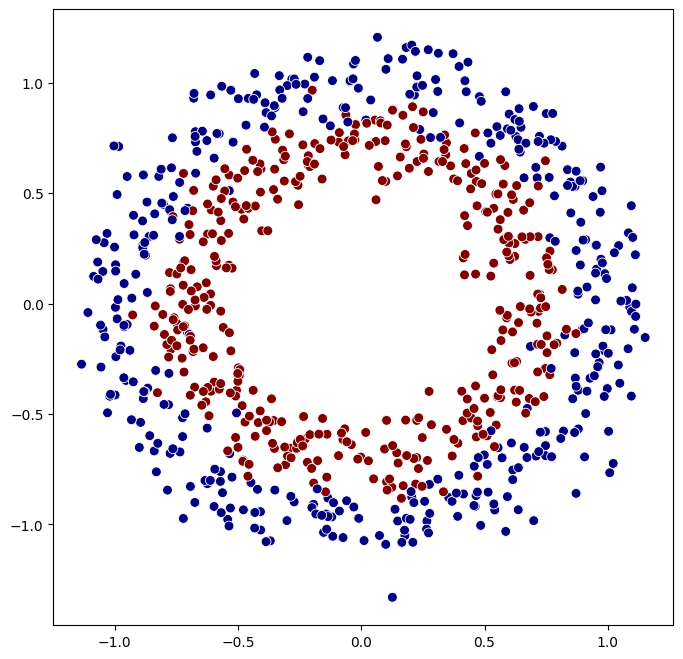

In [44]:
# Plot the training data
X_train = X_train.to('cpu')
Y_train = Y_train.to('cpu')
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], s=50, c=Y_train, edgecolors='w', linewidths=0.6, cmap=plt.cm.jet)
if save_figs:
    plt.savefig(f"plots/cluster_seed_{RANDOM_SEED}.png", dpi=300)

# Model

In [110]:
# Create a model
class MultiClassClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(num_features, 5),
            activation,
            # nn.Linear(10, 10),
            # nn.ReLU(),
            nn.Linear(5, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.linear(x)

In [111]:
# Define accuracy percentage function
def accuracy(y_pred, y_true):
    return 100*(torch.argmax(y_pred, dim=1) == y_true).float().mean()

In [112]:
# Create the model
model_0 = MultiClassClassifier(NUM_FEATURES, NUM_CLASSES).to(device)
LOSS_FUNC = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=LEARNING_RATE)

In [113]:
# # Initialize the model weights
# def init_weights(m):
#     if type(m) == nn.Linear:
#         torch.nn.init.xavier_uniform_(m.weight)
#         m.bias.data.fill_(0.01)

# model_0.apply(init_weights)

In [114]:
X_train.shape, Y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [115]:
# Move the data to the device
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

In [116]:
train_loss_values = []
test_loss_values = []

In [117]:
# Train the model
for epoch in range(EPOCHS):
    model_0.train()
    Y_pred = model_0(X_train)
    loss = LOSS_FUNC(Y_pred, Y_train.type(torch.long))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Append the loss values
    train_loss_values.append(loss.item())
    
    # Print the loss values and accuracy
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Train Loss: {loss.item():.4f} | Train Accuracy: {accuracy(Y_pred, Y_train):.4f}%", end=" | ")
    model_0.eval()
    with torch.no_grad():
        Y_test_pred = model_0(X_test)
        loss = LOSS_FUNC(Y_test_pred, Y_test.type(torch.long))
        if epoch % 10 == 0:
            print(f"Test Loss: {loss.item():.4f}, Test Accuracy: {accuracy(Y_test_pred, Y_test):.4f}%")
        test_loss_values.append(loss.item()) # Append the loss values

Epoch: 0, Train Loss: 1.5966 | Train Accuracy: 17.8750% | Test Loss: 1.5882, Test Accuracy: 22.0000%
Epoch: 10, Train Loss: 1.5301 | Train Accuracy: 50.1250% | Test Loss: 1.5214, Test Accuracy: 48.5000%
Epoch: 20, Train Loss: 1.4590 | Train Accuracy: 50.2500% | Test Loss: 1.4529, Test Accuracy: 47.5000%
Epoch: 30, Train Loss: 1.4001 | Train Accuracy: 49.7500% | Test Loss: 1.3999, Test Accuracy: 43.5000%
Epoch: 40, Train Loss: 1.3679 | Train Accuracy: 49.5000% | Test Loss: 1.3727, Test Accuracy: 41.0000%
Epoch: 50, Train Loss: 1.3539 | Train Accuracy: 49.0000% | Test Loss: 1.3611, Test Accuracy: 38.5000%
Epoch: 60, Train Loss: 1.3474 | Train Accuracy: 47.7500% | Test Loss: 1.3553, Test Accuracy: 35.5000%
Epoch: 70, Train Loss: 1.3436 | Train Accuracy: 48.5000% | Test Loss: 1.3512, Test Accuracy: 37.5000%
Epoch: 80, Train Loss: 1.3405 | Train Accuracy: 51.0000% | Test Loss: 1.3478, Test Accuracy: 39.0000%
Epoch: 90, Train Loss: 1.3372 | Train Accuracy: 52.7500% | Test Loss: 1.3445, Test 

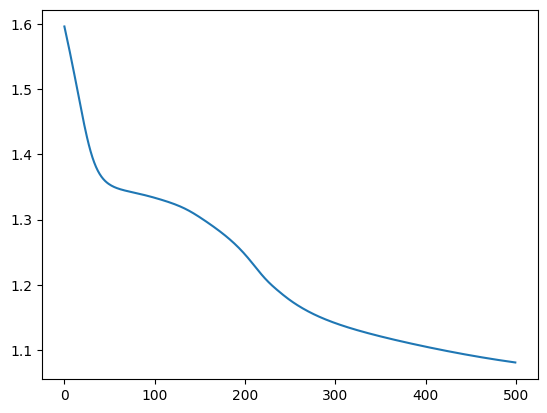

In [118]:
# Plot the loss values
plt.plot(train_loss_values, label="Train Loss")
if save_figs:
    plt.savefig(f"plots/train_loss_{activation_name}.png")

In [339]:
# Open numpy file and add the new data to it
try:
    np_data = np.load(f"data/{activation_name}.npy")
    np_data = np.append(np_data, [np.array(train_loss_values)], axis=0)

except FileNotFoundError:
    np_data = np.array([np.array(train_loss_values)])

# Save the updated data back to the numpy file
np.save(f"data/{activation_name}.npy", np_data)

In [340]:
np_data.shape

(20, 500)

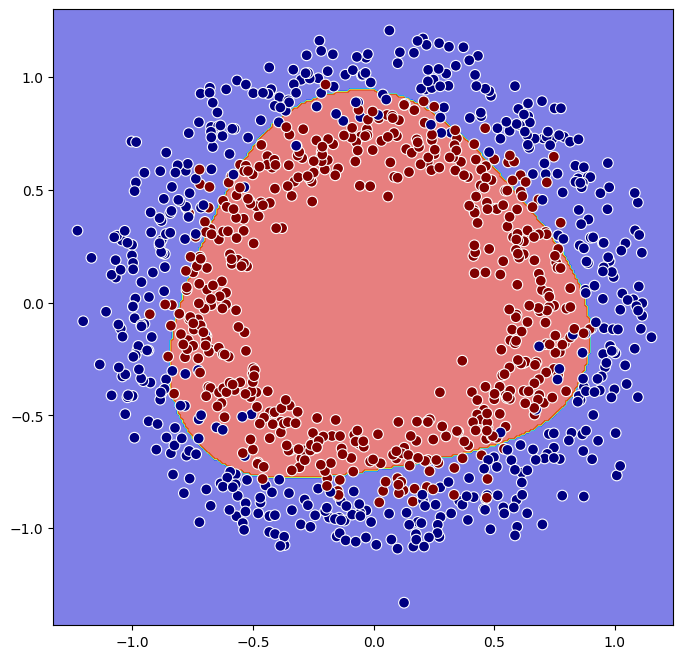

In [120]:
# Make a grid of points
padding = 0.1
x_min, x_max = X_blob[:, 0].min() - padding, X_blob[:, 0].max() + padding
y_min, y_max = X_blob[:, 1].min() - padding, X_blob[:, 1].max() + padding
xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.01), torch.arange(y_min, y_max, 0.01))
grid_points = torch.stack([xx.flatten(), yy.flatten()], axis=1)

# Make predictions on the grid
model_0.eval()
with torch.no_grad():
    Z = model_0(grid_points.to(device))
    Z = Z.argmax(dim=1).reshape(xx.shape)
# Figure
plt.figure(figsize=(8, 8))
# plt.colorbar(mappable=plt.contourf(xx, yy, Z.cpu(), cmap=plt.cm.jet, alpha=0.7), format='')
# Plot the decision boundary
plt.contourf(xx, yy, Z.cpu(), cmap=plt.cm.jet, alpha=0.5)
plt.scatter(X_blob[:, 0], X_blob[:, 1], s=60, edgecolors='w', linewidths=0.8 ,c=Y_blob, cmap=plt.cm.jet)

if save_figs:
    plt.savefig(f'plots/decision_boundary_{activation_name}.png', dpi=300)

In [342]:
# # Save the model
# from pathlib import Path

# MODEL_PATH = Path("models")
# MODEL_PATH.mkdir(parents=True, exist_ok=True)

# MODEL_NAME = "model_blobs.pt"
# MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)